<div style="
    background: linear-gradient(135deg, #eff6ff, #dbeafe);
    color: #1e3a8a;
    padding: 28px 32px;
    border-radius: 14px;
    box-shadow: 0 8px 18px rgba(0,0,0,0.10);
">
    <h1 style="margin:0;">📊 Classification Automatique de Produits E-commerce</h1>
    <h3 style="margin-top:8px; font-weight:normal;">
        NOTEBOOK 4 — Exploration & Feature Engineering des Images
    </h3>
    <p><b>Objectifs :</b></p>
    <ol style="margin-top:6px;">
        <li>Visualiser et analyser le dataset d’images</li>
        <li>Appliquer les prétraitements (gris, égalisation, redimensionnement)</li>
        <li>Extraire des features avec SIFT (Bag of Visual Words)</li>
        <li>Extraire des features avec Transfer Learning (VGG16)</li>
        <li>Réduire la dimensionnalité (PCA, t-SNE, UMAP)</li>
        <li>Appliquer un clustering non supervisé (K-Means, DBSCAN)</li>
        <li>Évaluer la séparabilité des classes</li>
    </ol>
    <p><b>Structure du notebook :</b></p>
    <ul>
        <li><b>3.1</b> Visualisation : exemples d’images</li>
        <li><b>3.2</b> Prétraitements</li>
        <li><b>3.3</b> Extraction de features (SIFT + VGG16)</li>
        <li><b>3.4</b> Réduction de dimensionnalité & Clustering</b></li>
    </ul>
    <p><b>Date :</b> Février 2026</p>
</div>


In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# Computer Vision
import cv2
from PIL import Image
from skimage import exposure, feature, color
from skimage.feature import hog, local_binary_pattern

# Deep Learning
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image as keras_image

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, 
    adjusted_rand_score, confusion_matrix
)
from sklearn.preprocessing import StandardScaler

# Utils
from tqdm import tqdm
import joblib
import json
from collections import Counter

# Reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

# Style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Imports réussis")
print(f"   TensorFlow: {tf.__version__}")
print(f"   OpenCV: {cv2.__version__}")

✅ Imports réussis
   TensorFlow: 2.20.0
   OpenCV: 4.11.0


## 1. CONFIGURATION

In [2]:
# Chemins
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "Data"
IMAGES_DIR = DATA_DIR / "images"
RESULTS_DIR = BASE_DIR / "outputs" / "exploration_images"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

METADATA_FILE = DATA_DIR / "data_images_corrected.csv"

# Catégories
CATEGORIES = [
    "Baby Care",
    "Beauty and Personal Care",
    "Computers",
    "Home Decor & Festive Needs",
    "Home Furnishing",
    "Kitchen & Dining",
    "Watches"
]

# Paramètres
IMG_SIZE = 224  # Pour VGG16
N_SAMPLES_VISUAL = 3  # Nombre d'exemples à afficher par catégorie

print(f" Configuration:")
print(f"   Images: {IMAGES_DIR}")
print(f"   Results: {RESULTS_DIR}")
print(f"   Catégories: {len(CATEGORIES)}")

 Configuration:
   Images: c:\Users\hp\Documents\AS3_2025-2026\SEMESTRE_1\NLP\Projet\Projet_NLP\Data\images
   Results: c:\Users\hp\Documents\AS3_2025-2026\SEMESTRE_1\NLP\Projet\Projet_NLP\outputs\exploration_images
   Catégories: 7


## 2. CHARGEMENT DONNÉES

In [33]:
# Chargement des métadonnées
df = pd.read_csv(METADATA_FILE)

print(f" Dataset:")
print(f"   Total: {len(df)} images")
print(f"\n Distribution par catégorie:")
print(df['main_category'].value_counts())

# Vérification de l'existence des images
valid_idx = [i for i, row in df.iterrows() if (IMAGES_DIR / row['image']).exists()]
df = df.loc[valid_idx].reset_index(drop=True)

print(f"\n✅ {len(df)} images valides trouvées")

# Création mapping catégories
cat_to_idx = {cat: i for i, cat in enumerate(CATEGORIES)}
df['cat_idx'] = df['main_category'].map(cat_to_idx)

 Dataset:
   Total: 1050 images

 Distribution par catégorie:
main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

✅ 1050 images valides trouvées


## 3. SECTION 3.1 : VISUALISATION - EXEMPLES D'IMAGES

**Référence P6_01 :** Section 3.1

 Exemples d'images par catégorie:

Baby Care: 150 images


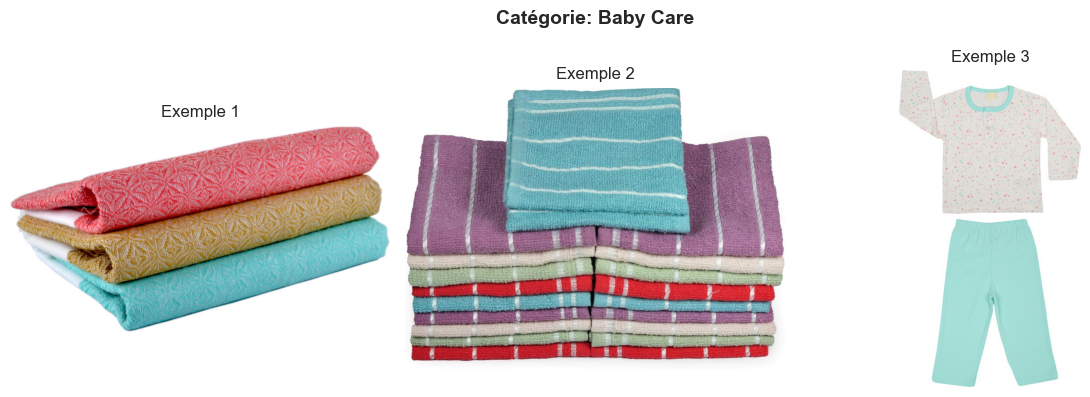

Beauty and Personal Care: 150 images


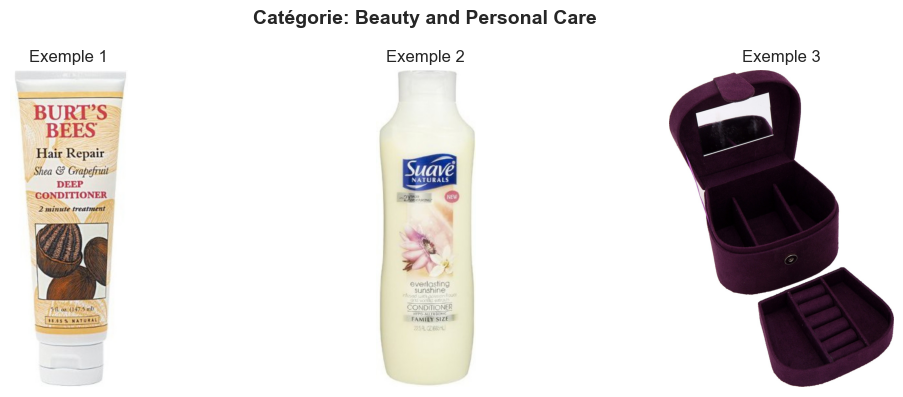

Computers: 150 images


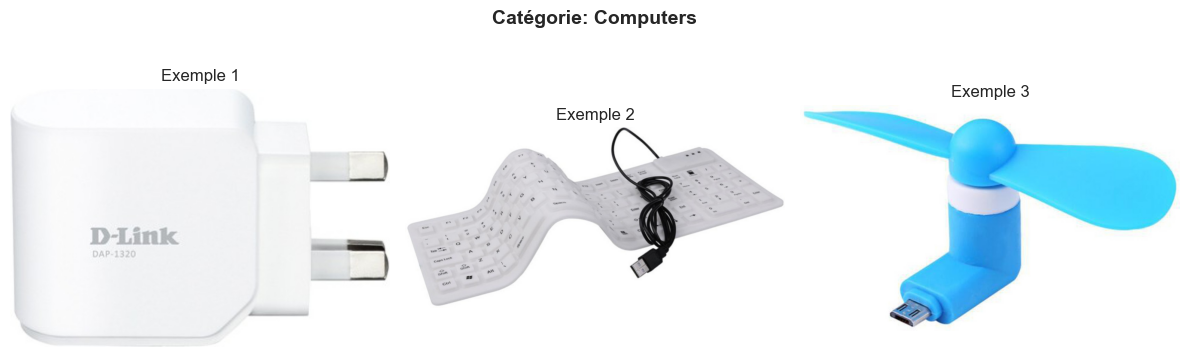

Home Decor & Festive Needs: 150 images


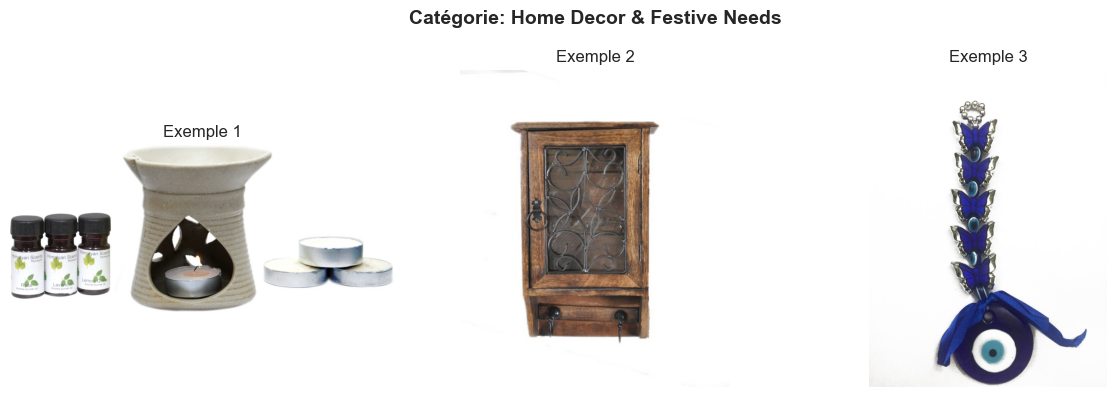

Home Furnishing: 150 images


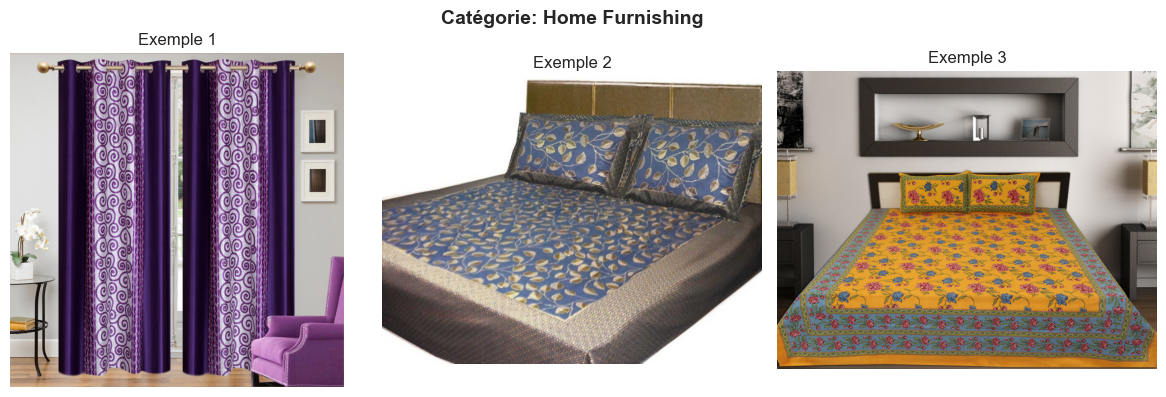

Kitchen & Dining: 150 images


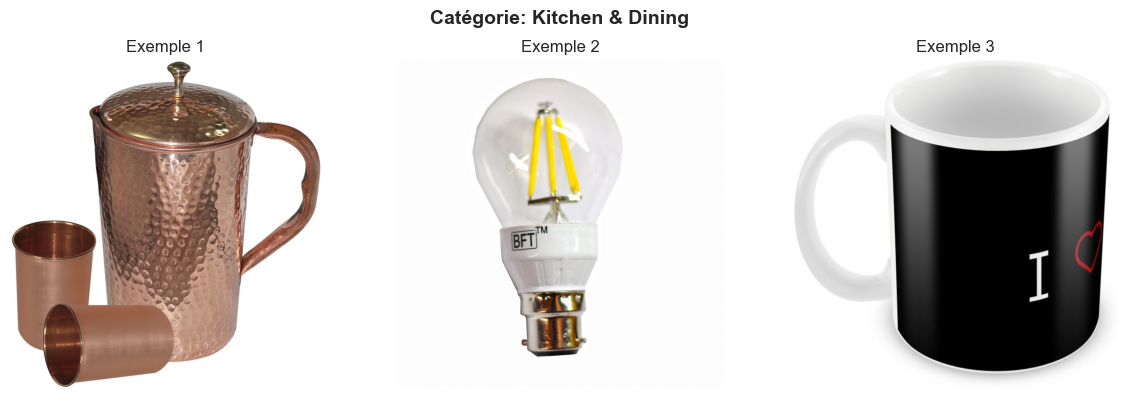

Watches: 150 images


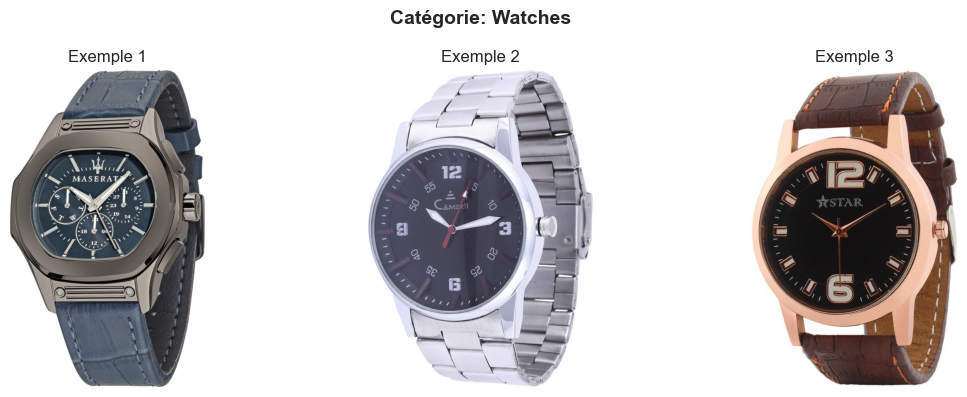


✅ Visualisations sauvegardées


In [4]:
# Visualiser exemples par catégorie (comme P6_01)
print(" Exemples d'images par catégorie:\n")

for cat in CATEGORIES:
    images_cat = df[df['main_category'] == cat]
    print(f"{cat}: {len(images_cat)} images")
    
    fig, axes = plt.subplots(1, N_SAMPLES_VISUAL, figsize=(12, 4))
    fig.suptitle(f"Catégorie: {cat}", fontsize=14, fontweight='bold')
    
    for i in range(min(N_SAMPLES_VISUAL, len(images_cat))):
        img_path = IMAGES_DIR / images_cat.iloc[i]['image']
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img_rgb)
        axes[i].axis('off')
        axes[i].set_title(f"Exemple {i+1}")
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'exemples_{cat.replace(" ", "_").replace("&", "and")}.png', 
                dpi=150, bbox_inches='tight')
    plt.show()

print("\n✅ Visualisations sauvegardées")

## 4. SECTION 3.2 : PRÉTRAITEMENTS DES IMAGES

**Référence P6_01 :** Sections 3.2.1 à 3.2.3

### 3.2.1. Passage en Niveaux de Gris

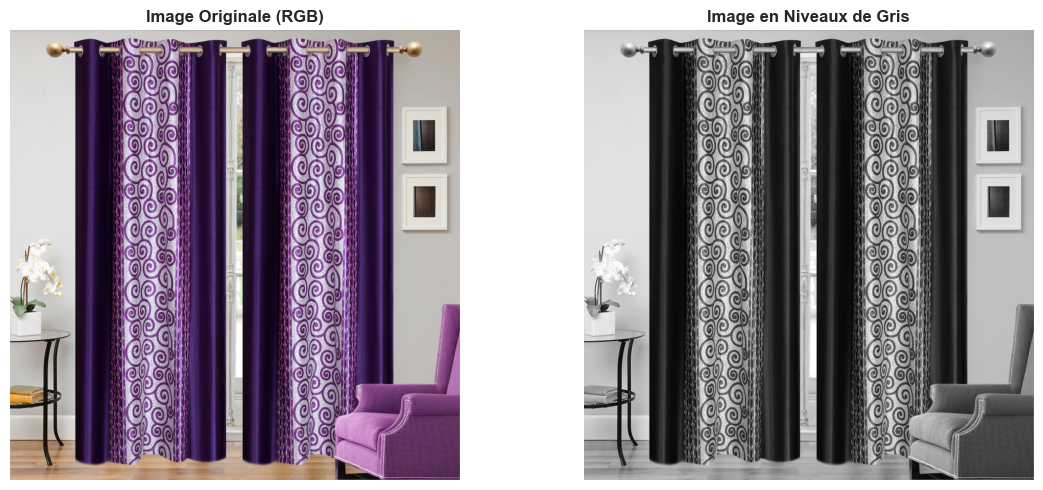

✅ Conversion niveaux de gris


In [5]:
# Exemple de conversion en gris
sample_img_path = IMAGES_DIR / df.iloc[0]['image']
img_original = cv2.imread(str(sample_img_path))
img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img_rgb)
axes[0].set_title('Image Originale (RGB)', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img_gray, cmap='gray')
axes[1].set_title('Image en Niveaux de Gris', fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'preprocessing_grayscale.png', dpi=150)
plt.show()

print("✅ Conversion niveaux de gris")

### 3.2.2. Égalisation d'Histogramme

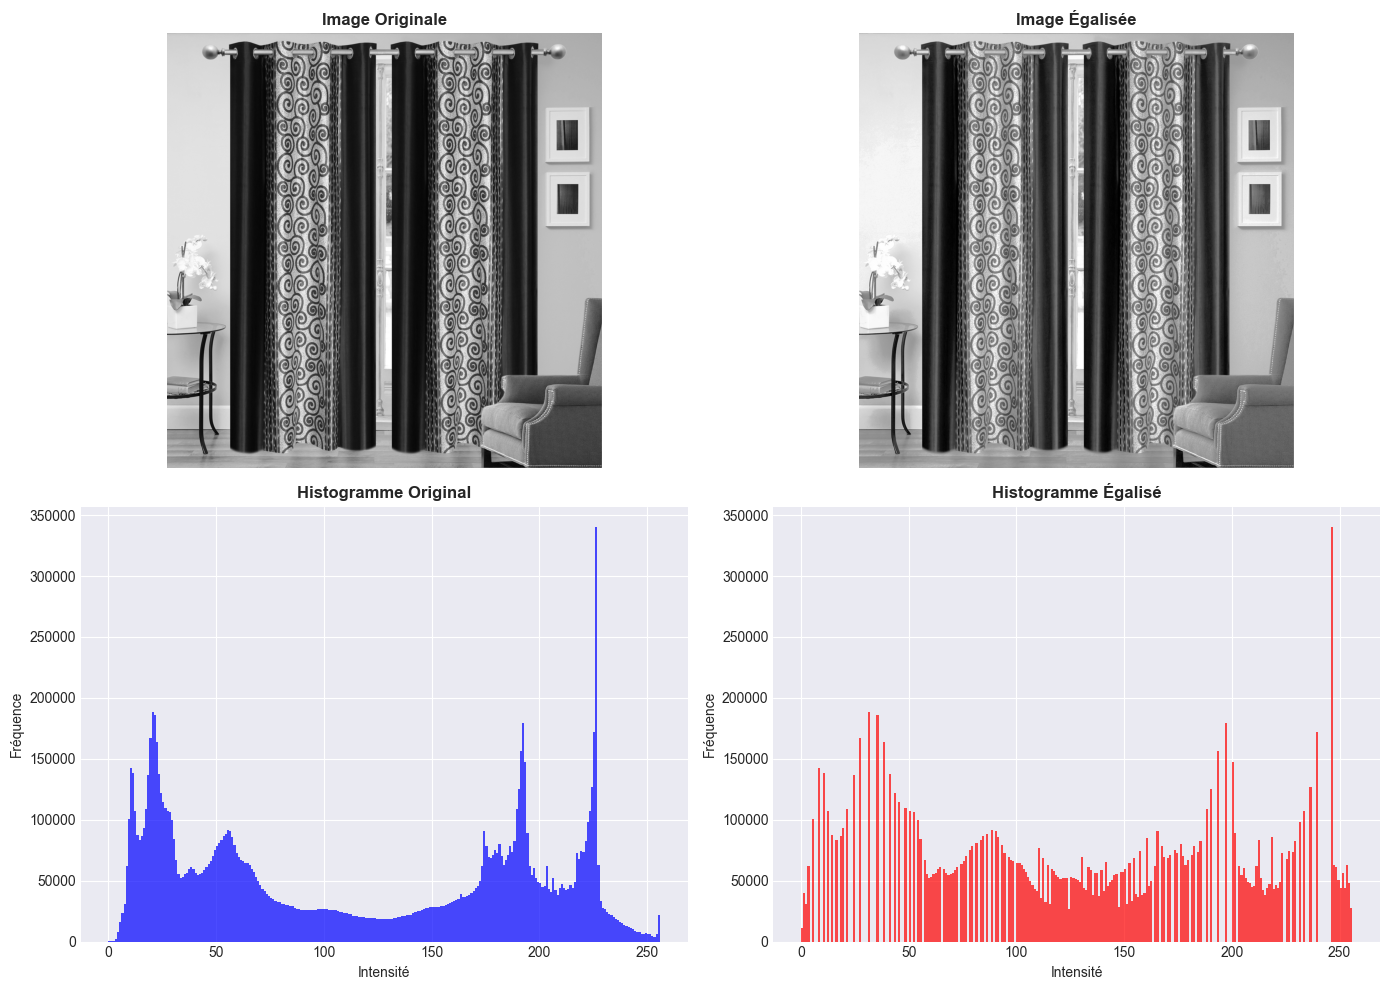

✅ Égalisation d'histogramme


In [6]:
# Égalisation histogramme (améliore contraste)
img_equalized = cv2.equalizeHist(img_gray)

# Histogrammes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Images
axes[0, 0].imshow(img_gray, cmap='gray')
axes[0, 0].set_title('Image Originale', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(img_equalized, cmap='gray')
axes[0, 1].set_title('Image Égalisée', fontweight='bold')
axes[0, 1].axis('off')

# Histogrammes
axes[1, 0].hist(img_gray.ravel(), 256, [0, 256], color='blue', alpha=0.7)
axes[1, 0].set_title('Histogramme Original', fontweight='bold')
axes[1, 0].set_xlabel('Intensité')
axes[1, 0].set_ylabel('Fréquence')

axes[1, 1].hist(img_equalized.ravel(), 256, [0, 256], color='red', alpha=0.7)
axes[1, 1].set_title('Histogramme Égalisé', fontweight='bold')
axes[1, 1].set_xlabel('Intensité')
axes[1, 1].set_ylabel('Fréquence')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'preprocessing_equalization.png', dpi=150)
plt.show()

print("✅ Égalisation d'histogramme")

### 3.2.3. Redimensionnement

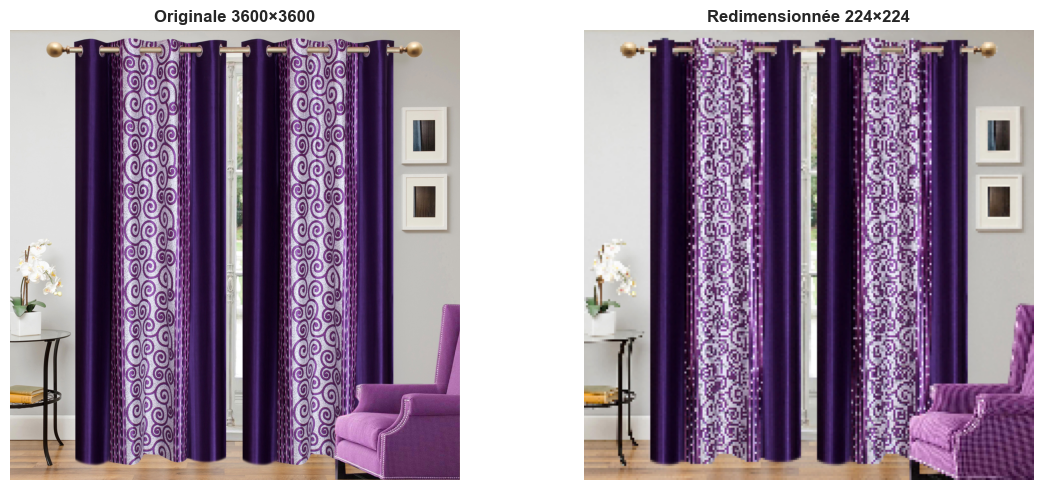

✅ Redimensionnement à 224×224


In [7]:
# Redimensionnement à taille fixe (pour VGG16)
img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img_rgb)
axes[0].set_title(f'Originale {img_rgb.shape[1]}×{img_rgb.shape[0]}', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img_resized)
axes[1].set_title(f'Redimensionnée {IMG_SIZE}×{IMG_SIZE}', fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'preprocessing_resize.png', dpi=150)
plt.show()

print(f"✅ Redimensionnement à {IMG_SIZE}×{IMG_SIZE}")

## 5. SECTION 3.3.1 : EXTRACTION FEATURES - SIFT

**Référence P6_01 :** Section 3.3.1 - Bag of Visual Words avec SIFT

### 3.3.1.1. Extraction Descripteurs SIFT

In [11]:
# Initialisation SIFT
sift = cv2.SIFT_create(nfeatures=500)

print(" Extraction des descripteurs SIFT...")

all_descriptors = []
sift_per_image = []
MAX_SIZE = 512  # Taille maximale

for idx, row in tqdm(df.iterrows(), total=len(df), desc="SIFT"):
    img_path = IMAGES_DIR / row['image']
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    
    if img is not None:
        # Redimensionner si nécessaire
        height, width = img.shape
        if max(height, width) > MAX_SIZE:
            scale = MAX_SIZE / max(height, width)
            new_size = (int(width * scale), int(height * scale))
            img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
        
        # SIFT
        try:
            keypoints, descriptors = sift.detectAndCompute(img, None)
            
            if descriptors is not None:
                all_descriptors.append(descriptors)
                sift_per_image.append(len(descriptors))
            else:
                sift_per_image.append(0)
        except cv2.error as e:
            print(f"Erreur SIFT sur {row['image']}: {e}")
            sift_per_image.append(0)
    else:
        sift_per_image.append(0)
    
    # Libérer mémoire tous les 100 images
    if (idx + 1) % 100 == 0:
        import gc
        gc.collect()

# Concatener
if all_descriptors:
    all_descriptors_concat = np.vstack(all_descriptors)
    print(f"\n✅ SIFT Extraction:")
    print(f"   Total descripteurs: {all_descriptors_concat.shape[0]:,}")
    print(f"   Dimensions: {all_descriptors_concat.shape[1]}")
    print(f"   Moyenne par image: {np.mean(sift_per_image):.1f}")
else:
    print(" Aucun descripteur extrait")

 Extraction des descripteurs SIFT...


SIFT: 100%|██████████| 1050/1050 [01:51<00:00,  9.44it/s]



✅ SIFT Extraction:
   Total descripteurs: 402,591
   Dimensions: 128
   Moyenne par image: 383.4


In [13]:
# Test sur une seule image d'abord
test_img_path = IMAGES_DIR / df.iloc[0]['image']
test_img = cv2.imread(str(test_img_path), cv2.IMREAD_GRAYSCALE)

print(f"Image originale: {test_img.shape}")

# Redimensionnement
test_img_resized = cv2.resize(test_img, (512, 512))
print(f"Image redimensionnée: {test_img_resized.shape}")

# SIFT
kp, des = sift.detectAndCompute(test_img_resized, None)
print(f"Keypoints: {len(kp)}")
print(f"Descripteurs: {des.shape if des is not None else 'None'}")

Image originale: (3600, 3600)
Image redimensionnée: (512, 512)
Keypoints: 500
Descripteurs: (500, 128)


### 3.3.1.2. Visualisation SIFT sur Exemple

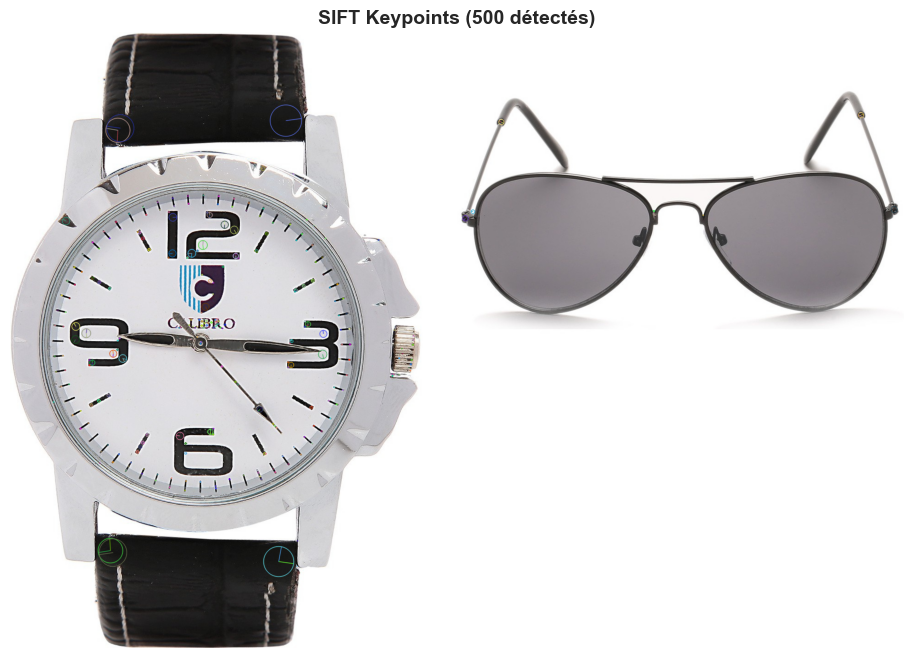

✅ 500 keypoints SIFT détectés


In [14]:
# Visualisation keypoints SIFT sur une image exemple
example_img_path = IMAGES_DIR / df.iloc[10]['image']
example_img = cv2.imread(str(example_img_path))
example_gray = cv2.cvtColor(example_img, cv2.COLOR_BGR2GRAY)

kp, des = sift.detectAndCompute(example_gray, None)
img_with_kp = cv2.drawKeypoints(example_img, kp, None, 
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
plt.title(f'SIFT Keypoints ({len(kp)} détectés)', fontsize=14, fontweight='bold')
plt.axis('off')
plt.savefig(RESULTS_DIR / 'sift_keypoints_example.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ {len(kp)} keypoints SIFT détectés")

### 3.3.1.3. Bag of Visual Words (BoVW)

In [15]:
# Création de vocabulaire visuel avec K-Means
print(" Construction du vocabulaire visuel (Bag of Words)...")

N_CLUSTERS = 100  # Taille du vocabulaire

# Échantillonnage pour accélérer (optionnel)
sample_size = min(50000, all_descriptors_concat.shape[0])
sample_idx = np.random.choice(all_descriptors_concat.shape[0], sample_size, replace=False)
descriptors_sample = all_descriptors_concat[sample_idx]

# K-Means pour créer vocabulaire
kmeans_bow = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10, max_iter=100)
kmeans_bow.fit(descriptors_sample)

print(f"✅ Vocabulaire créé: {N_CLUSTERS} mots visuels")

# Créer histogrammes BoVW pour chaque image
print("\n Création des histogrammes BoVW...")

bow_features = []

for descriptors in tqdm(all_descriptors, desc="BoVW"):
    if descriptors is not None and len(descriptors) > 0:
        # Assigner chaque descripteur au mot visuel le plus proche
        labels = kmeans_bow.predict(descriptors)
        # Créer histogramme
        hist, _ = np.histogram(labels, bins=N_CLUSTERS, range=(0, N_CLUSTERS))
        # Normaliser
        hist = hist / (hist.sum() + 1e-7)
        bow_features.append(hist)
    else:
        bow_features.append(np.zeros(N_CLUSTERS))

bow_features = np.array(bow_features)

print(f"\n BoVW Features: {bow_features.shape}")

# Sauvegarde
np.save(RESULTS_DIR / 'sift_bow_features.npy', bow_features)
joblib.dump(kmeans_bow, RESULTS_DIR / 'kmeans_bow.pkl')

print(" Features SIFT BoVW sauvegardées")

 Construction du vocabulaire visuel (Bag of Words)...
✅ Vocabulaire créé: 100 mots visuels

 Création des histogrammes BoVW...


BoVW: 100%|██████████| 1049/1049 [00:02<00:00, 462.95it/s]


 BoVW Features: (1049, 100)
 Features SIFT BoVW sauvegardées


## 6. SECTION 3.3.2 : EXTRACTION FEATURES - TRANSFER LEARNING VGG16

In [16]:
# Chargement VGG16 pré-entraîné
print(" Chargement VGG16 pré-entraîné...")

vgg16_model = VGG16(weights='imagenet', include_top=False, pooling='avg')

print(f" VGG16 chargé")
print(f"   Output shape: {vgg16_model.output_shape}")

 Chargement VGG16 pré-entraîné...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step
 VGG16 chargé
   Output shape: (None, 512)


#### Extraction des features VGG16

In [17]:
# Extraction des features VGG16
print(" Extraction features VGG16...")

vgg_features = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="VGG16"):
    img_path = IMAGES_DIR / row['image']
    
    try:
        # Chargement et préparation image
        img = keras_image.load_img(img_path, target_size=(224, 224))
        img_array = keras_image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        
        # Extraire features
        features = vgg16_model.predict(img_array, verbose=0)
        vgg_features.append(features.flatten())
    except:
        # Zéros si erreur
        vgg_features.append(np.zeros(512))

vgg_features = np.array(vgg_features)

print(f"\n✅ VGG16 Features: {vgg_features.shape}")

# Sauvegarder
np.save(RESULTS_DIR / 'vgg16_features.npy', vgg_features)

print("✅ Features VGG16 sauvegardées")

 Extraction features VGG16...


VGG16: 100%|██████████| 1050/1050 [30:33<00:00,  1.75s/it]


✅ VGG16 Features: (1050, 512)
✅ Features VGG16 sauvegardées


## 7. RÉDUCTION DE DIMENSIONNALITÉ

### 7.1. PCA sur SIFT BoVW

In [27]:
# Vérifions la correspondance
print(f"Shapes avant filtrage:")
print(f"  df: {len(df)}")
print(f"  bow_features: {len(bow_features)}")
print(f"  sift_2d: {len(sift_2d)}")

# Filtre de df pour ne garder que les images avec features SIFT
if len(bow_features) != len(df):
    # Identifier les indices valides (images avec descripteurs)
    valid_indices = [i for i, count in enumerate(sift_per_image) if count > 0]
    
    print(f"\n {len(df) - len(valid_indices)} images sans descripteurs SIFT")
    
    # Filtrer le DataFrame
    df_filtered = df.iloc[valid_indices].reset_index(drop=True)
    
    print(f"\n✅ Après filtrage:")
    print(f"  df_filtered: {len(df_filtered)}")
    print(f"  bow_features: {len(bow_features)}")
    
    # Utiliser df_filtered pour les visualisations
    df_viz = df_filtered
else:
    df_viz = df

print("\n✅ DataFrames synchronisés")

Shapes avant filtrage:
  df: 1049
  bow_features: 1049
  sift_2d: 1049

✅ DataFrames synchronisés


 PCA sur SIFT BoVW...
 PCA SIFT:
   Shape: (1049, 50)
   Variance expliquée: 93.29%


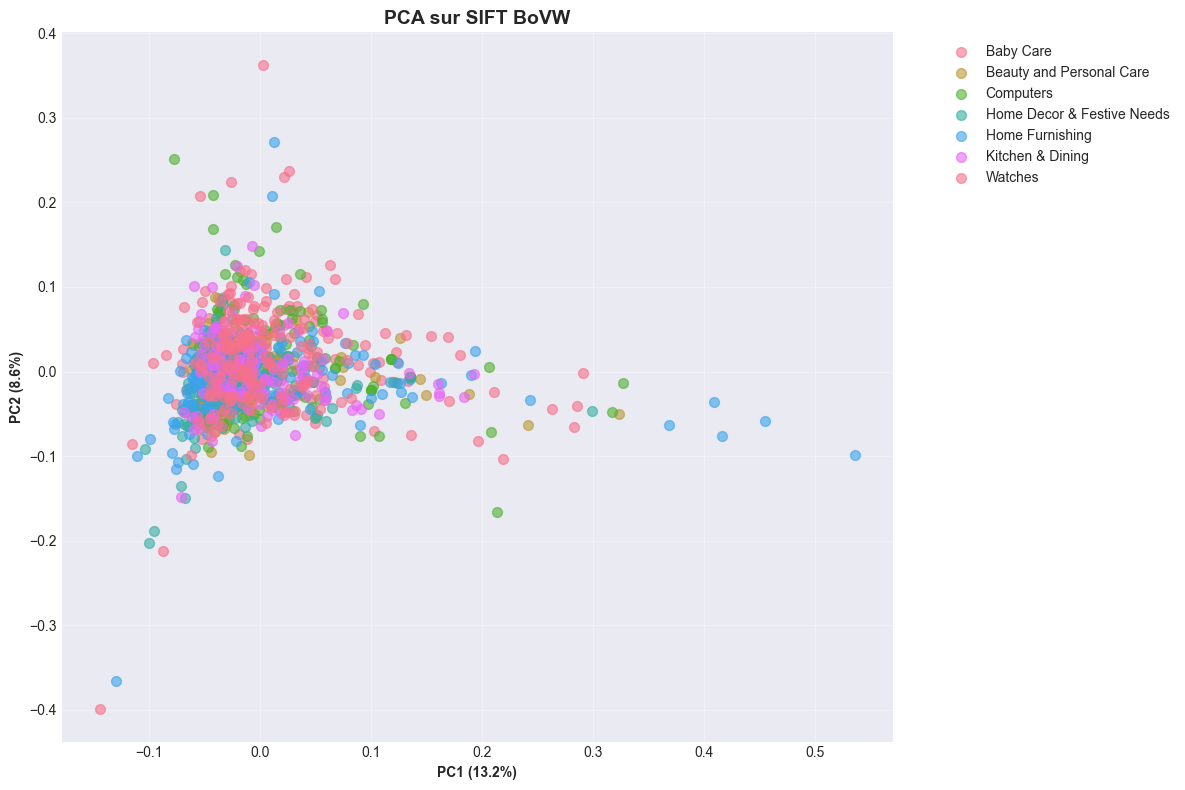

 PCA SIFT visualisé


In [28]:
# PCA sur SIFT BoVW
print(" PCA sur SIFT BoVW...")
pca_sift = PCA(n_components=50, random_state=42)
sift_pca = pca_sift.fit_transform(bow_features)

variance_explained = pca_sift.explained_variance_ratio_.sum()

print(f" PCA SIFT:")
print(f"   Shape: {sift_pca.shape}")
print(f"   Variance expliquée: {variance_explained:.2%}")

# Visualisation 2D
pca_2d_sift = PCA(n_components=2, random_state=42)
sift_2d = pca_2d_sift.fit_transform(bow_features)

plt.figure(figsize=(12, 8))
for cat in CATEGORIES:
    mask = df_viz['main_category'] == cat
    plt.scatter(sift_2d[mask, 0], sift_2d[mask, 1], 
               label=cat, alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca_2d_sift.explained_variance_ratio_[0]:.1%})', fontweight='bold')
plt.ylabel(f'PC2 ({pca_2d_sift.explained_variance_ratio_[1]:.1%})', fontweight='bold')
plt.title('PCA sur SIFT BoVW', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'pca_sift_bow.png', dpi=150, bbox_inches='tight')
plt.show()

print(" PCA SIFT visualisé")

### 7.2. t-SNE sur SIFT BoVW

 t-SNE sur SIFT BoVW...


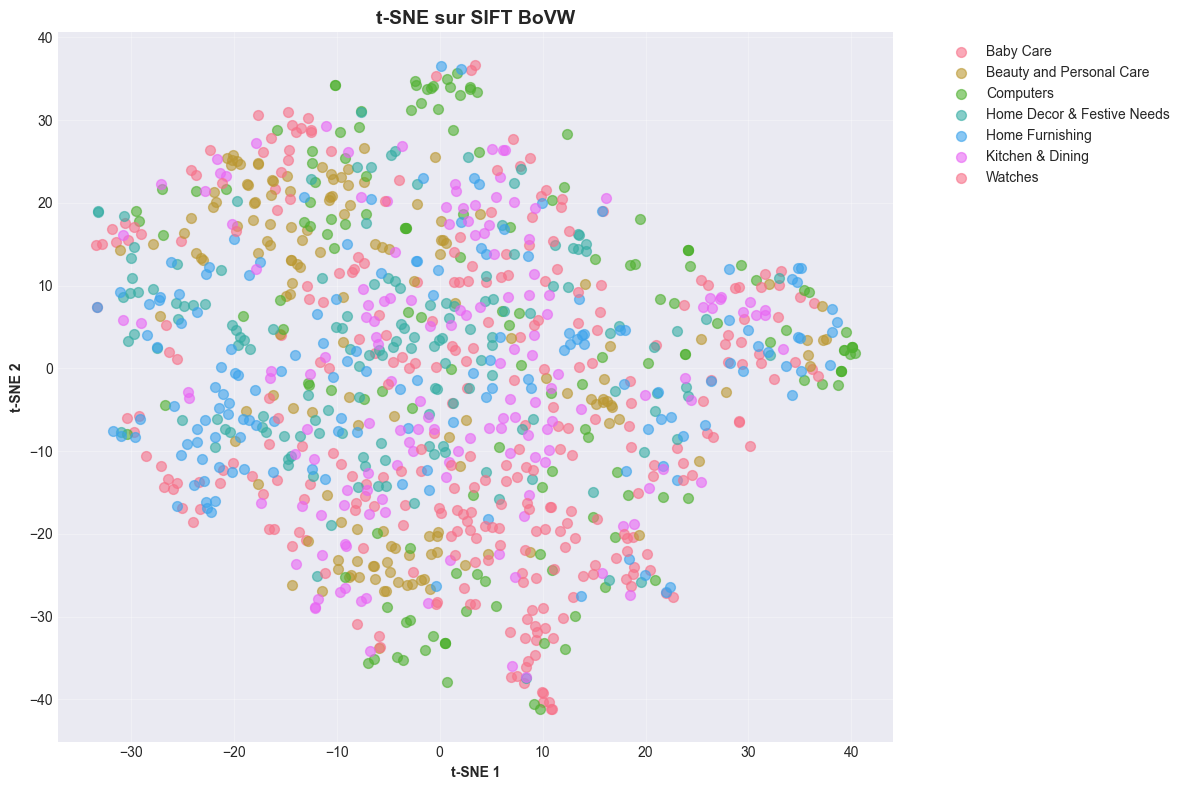

 t-SNE SIFT visualisé


In [29]:
# t-SNE sur SIFT (sur features PCA pour accélérer)
print(" t-SNE sur SIFT BoVW...")

tsne_sift = TSNE(n_components=2, random_state=42, perplexity=30)
sift_tsne = tsne_sift.fit_transform(sift_pca)

plt.figure(figsize=(12, 8))
for cat in CATEGORIES:
    mask = df['main_category'] == cat
    plt.scatter(sift_tsne[mask, 0], sift_tsne[mask, 1],
               label=cat, alpha=0.6, s=50)

plt.xlabel('t-SNE 1', fontweight='bold')
plt.ylabel('t-SNE 2', fontweight='bold')
plt.title('t-SNE sur SIFT BoVW', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tsne_sift_bow.png', dpi=150, bbox_inches='tight')
plt.show()

print(" t-SNE SIFT visualisé")

### 7.3. PCA sur VGG16

 PCA sur VGG16...
✅ PCA VGG16:
   Shape: (1050, 50)
   Variance expliquée: 72.45%


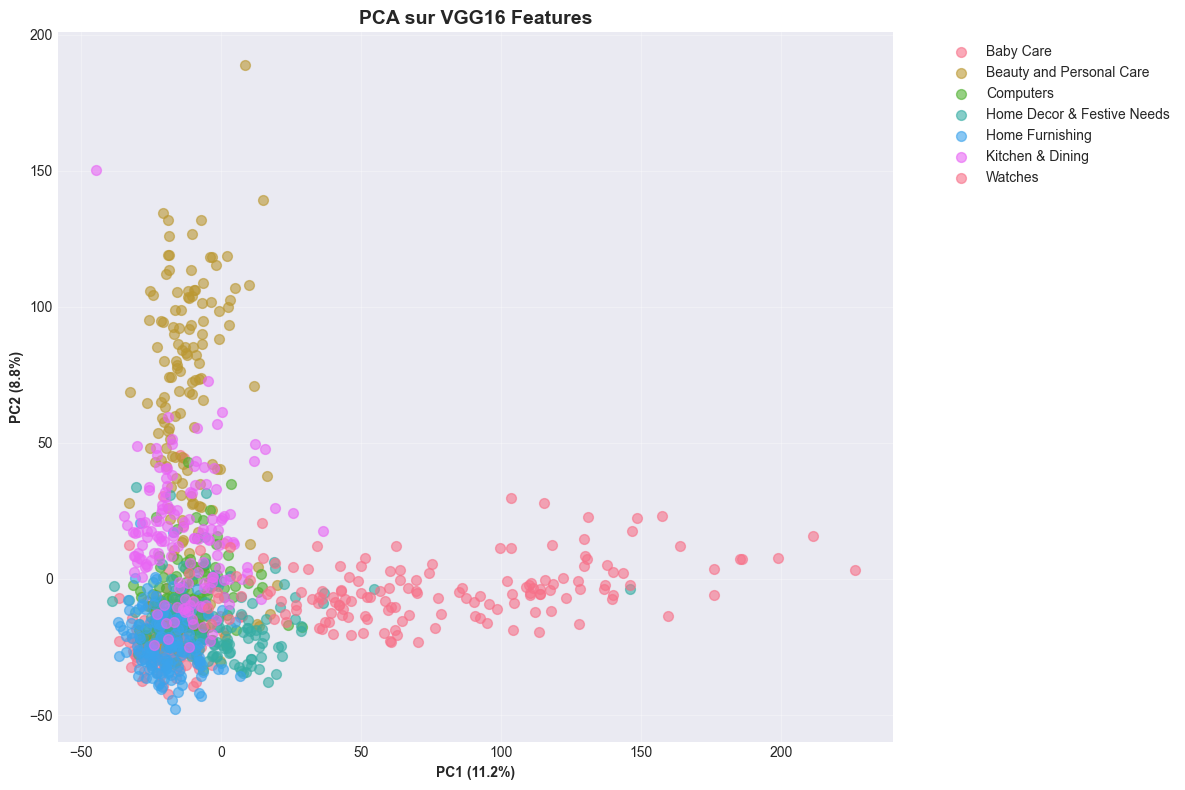

 PCA VGG16 visualisé


In [35]:
# PCA sur VGG16
print(" PCA sur VGG16...")

pca_vgg = PCA(n_components=50, random_state=42)
vgg_pca = pca_vgg.fit_transform(vgg_features)

variance_explained_vgg = pca_vgg.explained_variance_ratio_.sum()

print(f"✅ PCA VGG16:")
print(f"   Shape: {vgg_pca.shape}")
print(f"   Variance expliquée: {variance_explained_vgg:.2%}")

# Visualisation 2D
pca_2d_vgg = PCA(n_components=2, random_state=42)
vgg_2d = pca_2d_vgg.fit_transform(vgg_features)

plt.figure(figsize=(12, 8))
for cat in CATEGORIES:
    mask = df['main_category'] == cat
    plt.scatter(vgg_2d[mask, 0], vgg_2d[mask, 1],
               label=cat, alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca_2d_vgg.explained_variance_ratio_[0]:.1%})', fontweight='bold')
plt.ylabel(f'PC2 ({pca_2d_vgg.explained_variance_ratio_[1]:.1%})', fontweight='bold')
plt.title('PCA sur VGG16 Features', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'pca_vgg16.png', dpi=150, bbox_inches='tight')
plt.show()

print(" PCA VGG16 visualisé")

### 7.4. t-SNE sur VGG16

 t-SNE sur VGG16...


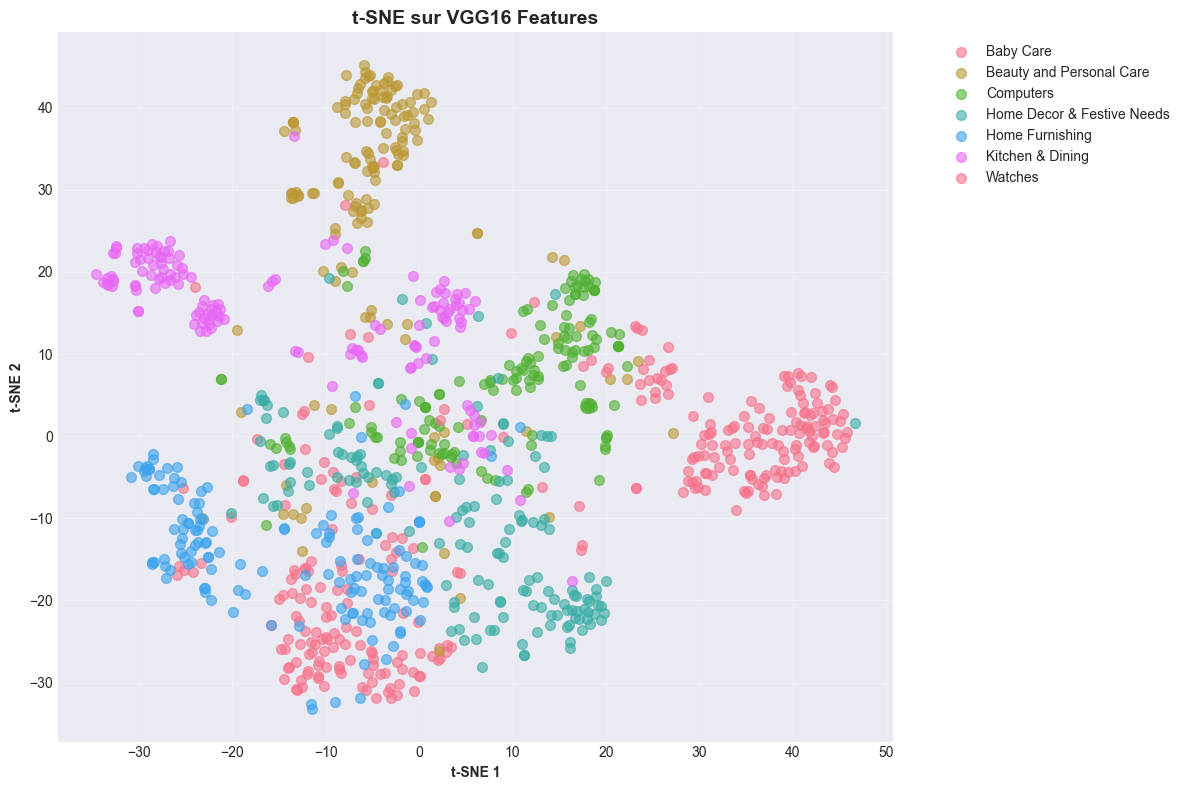

 t-SNE VGG16 visualisé


In [37]:
# t-SNE sur VGG16
print(" t-SNE sur VGG16...")

tsne_vgg = TSNE(n_components=2, random_state=42, perplexity=30)
vgg_tsne = tsne_vgg.fit_transform(vgg_pca)

plt.figure(figsize=(12, 8))
for cat in CATEGORIES:
    mask = df['main_category'] == cat
    plt.scatter(vgg_tsne[mask, 0], vgg_tsne[mask, 1],
               label=cat, alpha=0.6, s=50)

plt.xlabel('t-SNE 1', fontweight='bold')
plt.ylabel('t-SNE 2', fontweight='bold')
plt.title('t-SNE sur VGG16 Features', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tsne_vgg16.png', dpi=150, bbox_inches='tight')
plt.show()

print(" t-SNE VGG16 visualisé")

## 8. CLUSTERING NON-SUPERVISÉ

### 8.1. K-Means sur PCA VGG16

 K-Means Clustering sur VGG16 PCA...

 Métriques Clustering:
   Silhouette Score: 0.112
   Davies-Bouldin: 2.226
   Adjusted Rand Index: 0.331


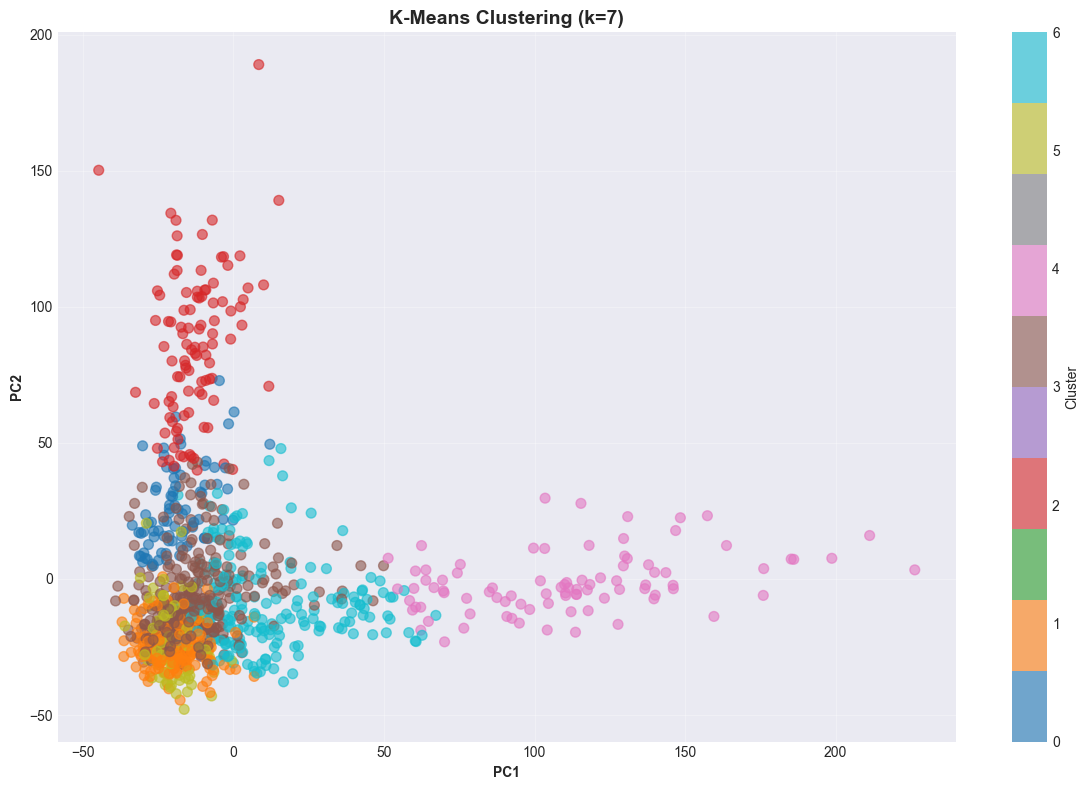

 Clustering K-Means terminé


In [38]:
# K-Means clustering
print(" K-Means Clustering sur VGG16 PCA...")

N_CLUSTERS_KMEANS = len(CATEGORIES)

kmeans = KMeans(n_clusters=N_CLUSTERS_KMEANS, random_state=42, n_init=20)
clusters = kmeans.fit_predict(vgg_pca)

# Métriques
sil_score = silhouette_score(vgg_pca, clusters)
db_score = davies_bouldin_score(vgg_pca, clusters)
ari_score = adjusted_rand_score(df['cat_idx'], clusters)

print(f"\n Métriques Clustering:")
print(f"   Silhouette Score: {sil_score:.3f}")
print(f"   Davies-Bouldin: {db_score:.3f}")
print(f"   Adjusted Rand Index: {ari_score:.3f}")

# Visualisation
plt.figure(figsize=(12, 8))
scatter = plt.scatter(vgg_2d[:, 0], vgg_2d[:, 1], c=clusters, 
                     cmap='tab10', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PC1', fontweight='bold')
plt.ylabel('PC2', fontweight='bold')
plt.title(f'K-Means Clustering (k={N_CLUSTERS_KMEANS})', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'clustering_kmeans.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Clustering K-Means terminé")

### 8.2. Matrice de Confusion Clustering

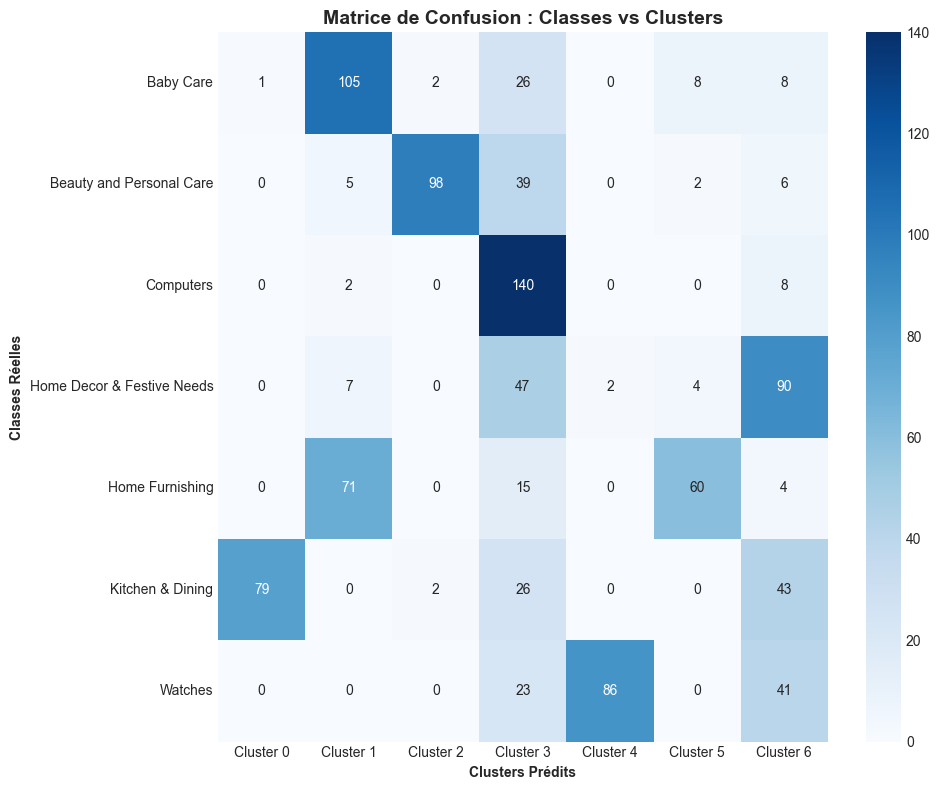

✅ Matrice de confusion générée


In [39]:
# Matrice de confusion : vraies classes vs clusters
cm = confusion_matrix(df['cat_idx'], clusters)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=[f'Cluster {i}' for i in range(N_CLUSTERS_KMEANS)],
           yticklabels=CATEGORIES)
plt.xlabel('Clusters Prédits', fontweight='bold')
plt.ylabel('Classes Réelles', fontweight='bold')
plt.title('Matrice de Confusion : Classes vs Clusters', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'confusion_matrix_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Matrice de confusion générée")

## 9. SAUVEGARDE FINALE

In [40]:
# Sauvegarder toutes les features et résultats
results = {
    'n_images': len(df),
    'n_categories': len(CATEGORIES),
    'sift_bow_shape': bow_features.shape,
    'vgg16_shape': vgg_features.shape,
    'pca_variance_sift': float(variance_explained),
    'pca_variance_vgg': float(variance_explained_vgg),
    'clustering_silhouette': float(sil_score),
    'clustering_davies_bouldin': float(db_score),
    'clustering_ari': float(ari_score)
}

with open(RESULTS_DIR / 'exploration_results.json', 'w') as f:
    json.dump(results, f, indent=2)

# Sauvegarder features réduites
np.save(RESULTS_DIR / 'sift_pca.npy', sift_pca)
np.save(RESULTS_DIR / 'vgg_pca.npy', vgg_pca)
np.save(RESULTS_DIR / 'sift_tsne.npy', sift_tsne)
np.save(RESULTS_DIR / 'vgg_tsne.npy', vgg_tsne)
np.save(RESULTS_DIR / 'clusters.npy', clusters)

print("\n" + "="*70)
print(" EXPLORATION COMPLÈTE TERMINÉE")
print("="*70)
print(f"\n Résultats sauvegardés dans: {RESULTS_DIR}")
print("\nFichiers générés:")
print("   - sift_bow_features.npy")
print("   - vgg16_features.npy")
print("   - Features réduites (PCA, t-SNE)")
print("   - Clusters K-Means")
print("   - Visualisations (PNG)")
print("   - Métriques (JSON)")


 EXPLORATION COMPLÈTE TERMINÉE

 Résultats sauvegardés dans: c:\Users\hp\Documents\AS3_2025-2026\SEMESTRE_1\NLP\Projet\Projet_NLP\outputs\exploration_images

Fichiers générés:
   - sift_bow_features.npy
   - vgg16_features.npy
   - Features réduites (PCA, t-SNE)
   - Clusters K-Means
   - Visualisations (PNG)
   - Métriques (JSON)
